# Measure stellar rotation periods from TESS light curves

In this notebook, we walk through downloading TESS FFI cutouts using TESSCut, generating light curve grids from those cutouts using the Causal Pixel Modeling procedure, and measuring rotation periods from those light curves using LombScargle periodograms.

## Set up notebook

**Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')


# Plotting program
import matplotlib.pyplot as plt

# System
import os
import sys
from glob import glob

# Good for reading/writing data tables
import pandas as pd

# Better math, numbers, and array functions
import numpy as np

# Astropy
from astropy.timeseries import LombScargle
from astropy.io import fits, ascii
from astropy.table import Table, join

# Download TESS
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import astropy.units as units

from astroquery.vizier import Vizier # then we import the Vizier() tool
from astroquery.xmatch import XMatch # ...and the Xmatch() tool

# TESS cpm
import tess_cpm as tess_cpm

Could not import regions, which is required for some of the functionalities of this module.


**Set up directories**

In [2]:
# these are the directories I have to work in
# make directories you want to work with, rename accordingly
# I also include a catalog directory for the project I'm working on, can be replaced accordingly

lightcurve_dir = 'Pleiades_Lightcurves/'  #20
ffi_dir = 'Pleiades_FFI_Cutouts/' #20
#dir_catalog = 'Auto_results_2024Jan06.csv'

# Note: if you change the names of the directories,
# the indeces will need to be changed in download_tess() and make_cpm()

**Define Functions**

Define a function to check if the TESS FFI cutout for a target has been downloaded. If not, download the 40x40 pixel cutout using TESScut.

In [3]:
def download_tess(target_data, dir_ffi):
    
    # target_data is a table element with data for a target star
    # dir_ffi is the directory where FFI cutouts are saved
    
    # test if files exist
    # if not, download
    # files for a target are identified by Gaia DR2 ID
    # this can be changed, it's coded like this because of the data available in the example table I use
    files_ffi = glob(dir_ffi+"*"+str(target_data['GaiaDR2'])+"*.fits")
    
    # during download, files are temporarily placed in new directory
    # files are renamed to contain Gaia ID and TESS sector, moved outside of new directory
    # new directory is deleted
    
    # if files exist, get available sectors
    # if there are more data, download new data
    

    if len(files_ffi) == 0:
        os.mkdir(dir_ffi+str(target_data['GaiaDR2'])+'/')
        cutout_coord = SkyCoord(target_data['RA_ICRS'], target_data['DE_ICRS'],unit = "deg")      
        manifest = Tesscut.download_cutouts(coordinates=cutout_coord, size=40, path=dir_ffi+
                                            str(target_data['GaiaDR2'])+'/')
        dl_files = glob(dir_ffi+str(target_data['GaiaDR2'])+"/*")
        
        for d in dl_files:
            sector = d[47:49]
            os.rename(d, dir_ffi+str(target_data['GaiaDR2'])+'-Sector_'+sector+'.fits')
        os.rmdir(dir_ffi+str(target_data['GaiaDR2'])+'/')
        files_ffi = glob(dir_ffi+str(target_data['GaiaDR2'])+"*")
    else:
        downloaded_sectors = []
        for f in files_ffi:
            sector = f[46:48]
            downloaded_sectors.append(int(sector))
        os.mkdir(dir_ffi+str(target_data['GaiaDR2'])+'/')
        cutout_coord = SkyCoord(target_data['RA_ICRS'], target_data['DE_ICRS'],unit = "deg")
        available_sectors = Tesscut.get_sectors(coordinates=cutout_coord)
        for s in available_sectors['sector']:
            if(not(s in downloaded_sectors)):
                manifest = Tesscut.download_cutouts(coordinates=cutout_coord, size=40, path=dir_ffi+
                                                    str(target_data['GaiaDR2'])+'/', sector=s)
        dl_files = glob(dir_ffi+str(target_data['GaiaDR2'])+"/*")
        for d in dl_files:
            sector = d[47:49]
            os.rename(d, dir_ffi+str(target_data['GaiaDR2'])+'-Sector_'+sector+'.fits')
        os.rmdir(dir_ffi+str(target_data['GaiaDR2'])+'/')
        files_ffi = glob(dir_ffi+str(target_data['GaiaDR2'])+"*")
        
    # Check data sizes
    # delete any small files
    files = glob(dir_ffi+'*')
    for file in files:
        bsize = os.path.getsize(file) #size in bytes
        if (bsize < 200):
            os.remove(file)
            
    return files_ffi
    
    


Define functions to extract lightcurves from TESS FFI cutouts using Causal Pixel Modeling procedure as implemented in the **unpopular** package (Hattori, 2022). We are using an earlier version of this package here.

In [4]:
def cpm_do(file,t_row=20, t_col=20, excl=4):
    
    # causal pixel modeling procedure to generate light curves from FFI without systematics
    # our FFI cutouts are 40x40, so our target is on pixel (20,20)
    # exclusion zone set to 4 pixels for systematics modeling
    
    cpm = tess_cpm.CPM(file, remove_bad=True)
    cpm.set_target(t_row, t_col)
    cpm.set_exclusion(excl)
    cpm.set_predictor_pixels(256, method='similar_brightness') # cosine_similarity
    cpm.lsq(0.1, rescale=True, polynomials=False)
#    tess_cpm.summary_plot(cpm, 15)
    #aperture_lc, lc_matrix = cpm.get_aperture_lc(box=1, show_pixel_lc=True, show_aperture_lc=True)
    time = cpm.time
    flux = cpm.rescaled_target_fluxes - cpm.lsq_prediction
    return time, flux

def make_cpm(target_data, dir_lightcurve, dir_ffi, excl=4, mad_cut=20):
    
    # first check if we have all FFIs downloaded for a target
    files = download_tess(target_data, dir_ffi)

    # then check for each FFI if light curves exist
    # if not, make 5x5 light curve grid centered on target
    for f in files:
        csv_file = dir_lightcurve + f[21:48] + '.csv'
        lc_test = glob(csv_file)
        if np.size(lc_test) == 0:
            time, flux = [], []
            lc_table = Table()
            rows = range(18, 23)
            cols = range(18, 23)
            for r in rows:
                for c in cols:
                    flux_name = 'Flux_'+str(r)+'_'+str(c)
                    this_time, this_flux = cpm_do(f,t_row=r,t_col=c,excl=excl)
                    mad = np.nanmedian(np.abs(this_flux*100))
                    if mad < mad_cut:
                        time = this_time
                        flux = this_flux
                    else:
                        time = this_time
                        flux = np.zeros(len(this_flux))
                    lc_table['Time'] = time
                    lc_table[flux_name] = flux
              
            
            ascii.write(lc_table, csv_file, format = 'csv', overwrite = True)
    lc_files = glob(dir_lightcurve+"*"+str(target_data['GaiaDR2'])+"*.csv")
    return lc_files


Define function to measure the period of a signal from a lightcurve using LombScargle periodogram.

In [5]:
def LS_Period(time, flux, pmin=0.1, pmax=30.0):
    fmax = 1/pmin # 0.1 days
    fmin = 1/pmax # 50 days
    freq, power = LombScargle(time, flux).autopower(minimum_frequency=fmin, maximum_frequency=fmax)
    return 1/freq[np.argmax(power)],np.max(power)

## Benchmark example

Let's start with a well-studied benchmark cluster that should have well behaved light curves. We will use the Pleiades. It is young, relatively close, and has rotation periods in the literature. This provides a good population of stars that are not too close together, not too faint, and are still rotating rapidly enough to be within TESS's optimal detection range. We will use the table published in Curtis et al. 2020 which includes rotational data for a few benchmark clusters for comparison including the Pleiades. The Pleiades periods are measured from K2 light curves and published in the earlier Rebull et al. 2016.

In [6]:
# download the catalog

vizier_code = 'J/ApJ/904/140/table5'

query_catalog = Vizier()

query_catalog.ROW_LIMIT = -1

curtis_rot = query_catalog.get_catalogs(vizier_code)[0]

curtis_rot

Cluster,Age,Av,GaiaDR2,OName,RA_ICRS,DE_ICRS,BP-RP,__BP-RP_0,Gmag,GMag,Teff,Prot,R147,Simbad,_RA.icrs,_DE.icrs
,Gyr,mag,,,deg,deg,mag,mag,mag,mag,K,d,,,deg,deg
str12,float32,float32,int64,str14,float64,float64,float64,float64,float64,float64,float32,float64,int16,str6,float64,float64
Pleiades,0.120,0.120,67618285777617664,EPIC 210990525,53.882158,22.823390,0.710300,0.660386,9.72950,3.95639,6291.70,2.795300,0,Simbad,53.882158,22.823390
Pleiades,0.120,0.120,67832346947351424,EPIC 211051975,54.046203,23.806264,3.146000,3.096090,17.26980,11.49670,3122.60,0.549000,0,Simbad,54.046203,23.806264
Pleiades,0.120,0.120,64597927335800064,EPIC 210977505,54.101510,22.623601,1.772100,1.722190,13.51830,7.74519,4036.81,11.180500,0,Simbad,54.101510,22.623601
Pleiades,0.120,0.120,67724697887107200,EPIC 211010818,54.160077,23.145484,3.170300,3.120390,17.55940,11.78630,3110.94,0.304000,0,Simbad,54.160077,23.145484
Pleiades,0.120,0.120,67756789882795008,EPIC 211025925,54.485193,23.382239,2.797200,2.747290,15.88740,10.11430,3304.18,0.896900,0,Simbad,54.485193,23.382239
Pleiades,0.120,0.120,64671903852618624,EPIC 210969800,54.594179,22.499485,0.750100,0.700186,9.93380,4.16069,6157.14,2.111600,0,Simbad,54.594179,22.499485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ruprecht 147,2.700,0.300,4183947102991940608,EPIC 219675090,289.266390,-16.135371,1.841300,1.716800,15.31960,7.66160,4042.11,17.900000,1,Simbad,289.266390,-16.135371


Let's isolate the Pleiades data.

In [7]:
pleiades_index = np.where(curtis_rot['Cluster'] == 'Pleiades')[0]

curtis_rot[pleiades_index]

Cluster,Age,Av,GaiaDR2,OName,RA_ICRS,DE_ICRS,BP-RP,__BP-RP_0,Gmag,GMag,Teff,Prot,R147,Simbad,_RA.icrs,_DE.icrs
,Gyr,mag,,,deg,deg,mag,mag,mag,mag,K,d,,,deg,deg
str12,float32,float32,int64,str14,float64,float64,float64,float64,float64,float64,float32,float64,int16,str6,float64,float64
Pleiades,0.120,0.120,67618285777617664,EPIC 210990525,53.882158,22.823390,0.710300,0.660386,9.72950,3.95639,6291.70,2.795300,0,Simbad,53.882158,22.823390
Pleiades,0.120,0.120,67832346947351424,EPIC 211051975,54.046203,23.806264,3.146000,3.096090,17.26980,11.49670,3122.60,0.549000,0,Simbad,54.046203,23.806264
Pleiades,0.120,0.120,64597927335800064,EPIC 210977505,54.101510,22.623601,1.772100,1.722190,13.51830,7.74519,4036.81,11.180500,0,Simbad,54.101510,22.623601
Pleiades,0.120,0.120,67724697887107200,EPIC 211010818,54.160077,23.145484,3.170300,3.120390,17.55940,11.78630,3110.94,0.304000,0,Simbad,54.160077,23.145484
Pleiades,0.120,0.120,67756789882795008,EPIC 211025925,54.485193,23.382239,2.797200,2.747290,15.88740,10.11430,3304.18,0.896900,0,Simbad,54.485193,23.382239
Pleiades,0.120,0.120,64671903852618624,EPIC 210969800,54.594179,22.499485,0.750100,0.700186,9.93380,4.16069,6157.14,2.111600,0,Simbad,54.594179,22.499485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pleiades,0.120,0.120,65775195052996608,EPIC 211065426,59.604825,24.016130,2.963500,2.913590,16.46490,10.69180,3211.97,0.620900,0,Simbad,59.604825,24.016130


Let's plot the color-period diagram using the data here.

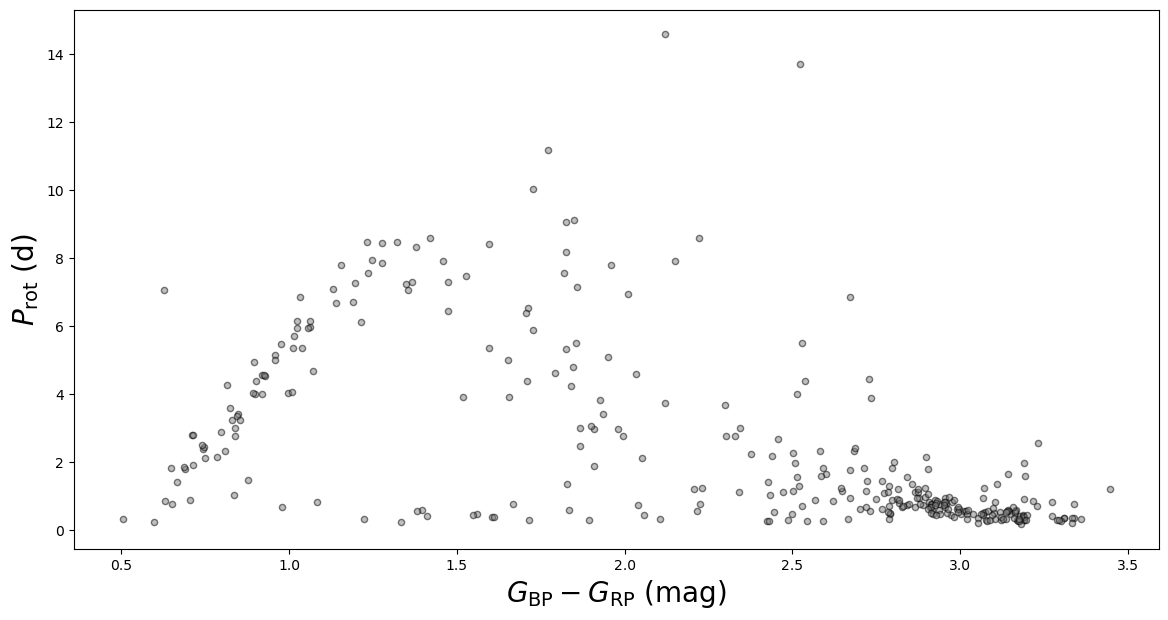

In [8]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(curtis_rot['BP-RP'][pleiades_index], curtis_rot['Prot'][pleiades_index], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel(r'$P_{\rm rot}$ (d)', fontsize = 20)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$ (mag)', fontsize = 20)

plt.show()

We can see the slow rotating sequence ranging from 0.5 to 1.5 in BP-RP, the rapid branch from 1.5 to 2.5, and the stars with stalled spindown beyond that. Now let's try getting a rotation period using TESS.

In [9]:
target_index = pleiades_index[0]

download_tess(curtis_rot[target_index], ffi_dir)

['Pleiades_FFI_Cutouts/67618285777617664-Sector_70.fits',
 'Pleiades_FFI_Cutouts/67618285777617664-Sector_71.fits',
 'Pleiades_FFI_Cutouts/67618285777617664-Sector_42.fits',
 'Pleiades_FFI_Cutouts/67618285777617664-Sector_43.fits',
 'Pleiades_FFI_Cutouts/67618285777617664-Sector_44.fits']

We have five FFIs for this target. This target was observed in three consecutive sectors in Cycle 4 and two consecutive sectors in Cycle 6. Lets make the light curves for this target.

In [10]:
lc_list = make_cpm(curtis_rot[target_index], lightcurve_dir, ffi_dir)

lc_list

['Pleiades_Lightcurves/67618285777617664-Sector_70.csv',
 'Pleiades_Lightcurves/67618285777617664-Sector_71.csv',
 'Pleiades_Lightcurves/67618285777617664-Sector_44.csv',
 'Pleiades_Lightcurves/67618285777617664-Sector_43.csv',
 'Pleiades_Lightcurves/67618285777617664-Sector_42.csv']

Now we have data for a light curve grid for each available sector for this target. Let's plot some light curves and measure some rotation periods.

In [11]:
# open the lightcurve file for Sector 70

lc_table = ascii.read(lc_list[0])

lc_table

Time,Flux_18_18,Flux_18_19,Flux_18_20,Flux_18_21,Flux_18_22,Flux_19_18,Flux_19_19,Flux_19_20,Flux_19_21,Flux_19_22,Flux_20_18,Flux_20_19,Flux_20_20,Flux_20_21,Flux_20_22,Flux_21_18,Flux_21_19,Flux_21_20,Flux_21_21,Flux_21_22,Flux_22_18,Flux_22_19,Flux_22_20,Flux_22_21,Flux_22_22
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3208.795627514142,-0.010398235114471799,0.0036412116538968586,0.012781488546618203,0.00408976755338708,0.0002996382379176765,-0.005553032331488517,-0.002393293595583934,0.00225903782248138,0.005430542293477503,0.011111726376473063,0.0031466572963883,0.00020622871653588892,0.0009677389368634715,0.007539364932479753,0.0045537469439653755,-0.0034505914853613096,0.0013741955707569364,0.00304305901788382,0.00579657248570517,0.0026356940597517253,0.005176133470409017,0.0031566845034360913,0.004891993015787688,0.0029000330205045666,0.008161988202788573
3208.797942520906,-0.0035329994840167522,0.008138777267839847,0.002619591598340021,-0.010420248048847558,-0.01605467145999162,0.006649408014516522,0.0009619493713532989,-0.003322796855811938,0.004705514689386181,0.001224843399477038,0.005378055291724193,0.00370598299765601,0.005405057445935002,-0.0004597873776401862,0.003435531549927595,-0.0032773825220753228,0.009828403293100432,0.007205582543450717,0.0029453146498094745,-0.0020523499365279196,0.010790135578799376,0.005740962624267487,0.0009139622563298921,0.002838853544703812,0.00480400676715409
3208.8002575279033,-0.0011629858832962192,-0.004773568999383526,-0.0031551511277723154,-0.0010542402266571216,0.00802952114532296,-0.015501402829954936,0.0034394403529521833,0.0025077269562060467,0.0028768197763494596,0.002043000752562696,-0.001384502123254805,0.002789236771363751,0.0026410186017520876,0.0011261173584208306,-0.005928435476920013,0.01506599129768671,0.0030398710266036633,0.005740648023803807,0.004581068592457743,0.0004458974092805823,-0.001984863627458422,-0.0023681307156293574,0.004780688007266276,-0.0021605314053576574,0.001442767565979719
3208.802572534667,0.0011299219307088215,-0.009175569675924145,0.006244079948639403,-0.0038831365633287263,0.002109050426742698,0.00021897294048200955,0.010145119893178123,0.012564615524776057,0.0029318739034206454,0.009124322907018367,0.0008378528860992773,0.0001713073561228906,0.004599005794755029,0.003828967660469307,-0.003327400227986943,-0.002206723140129485,0.003384812908251336,0.0015477291877312171,0.0037538318438329887,0.0005673597423914156,-0.0017736793229075065,0.004034350418536947,0.006280579764678551,0.002132338688742741,0.0009683890997957967
3208.8048875414306,-0.013376352288330118,0.0023648779295510902,0.002620765281545756,-0.005810800054696141,-0.0021599108268004485,0.005079183585565028,-0.002301538917311885,0.0002061712264802562,-0.0033864783837637136,0.0001898220997156308,-0.003991082712153204,0.0036759683005575805,0.001718550219556081,-0.004597044211838264,-0.001853748174504899,0.005049970757563971,0.0018417385456993007,0.0074939967004871155,-0.0027199795453854425,-0.0010492632236992483,-0.009113149185815406,0.006078249297686966,0.001846025026227438,-0.0005732798469615386,-0.004565516763196387
3208.8072025484275,-0.007997798106374798,0.0009191177103047288,-0.0007753540134713965,0.008736495684119161,0.002763637817148723,-0.004235095925132937,0.010038769488411536,0.008156130571525089,0.0023835661390396723,0.007734002490660252,0.006955797925850327,-8.311639038557916e-05,0.000949878651636149,0.00022788574328280742,0.0055333730884320476,0.007036509099880295,0.0063779715183751515,0.0077682730851130755,0.002634479107126511,-0.002473157159600392,-0.0028435662776753468,0.005710544313373589,-0.0030993205338289975,0.0024656420629006193,0.004849440500711122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233.8089067761316,-0.007980111299463744,-0.008

We really only need to look at the center pixel for now. Let's plot.

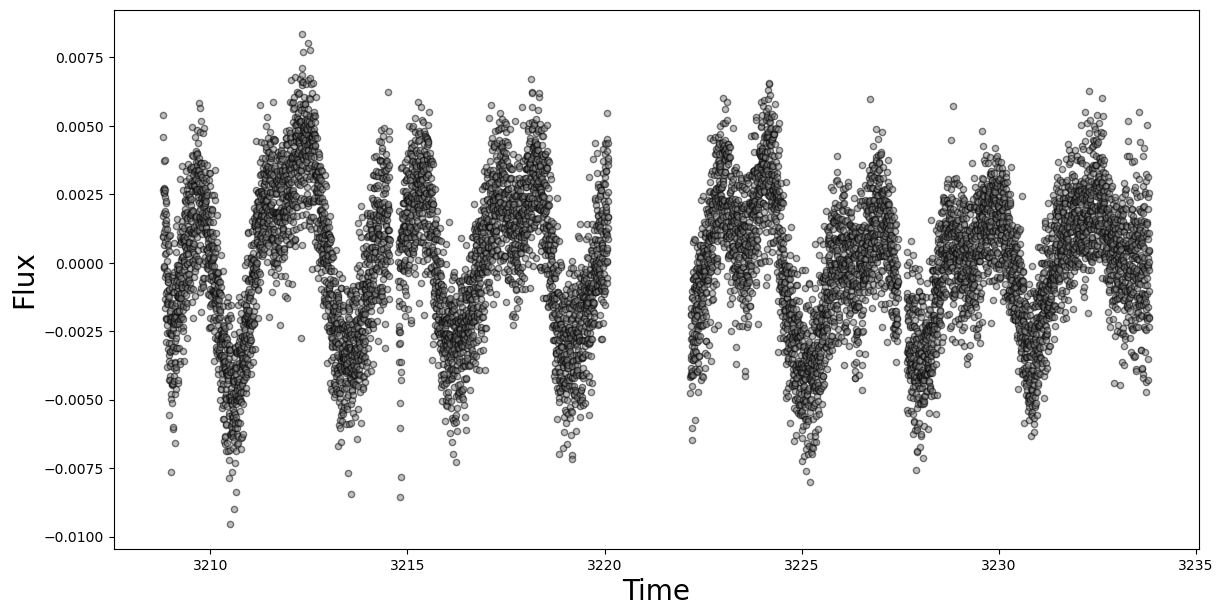

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

Let's measure a rotation period. First, plot a periodogram

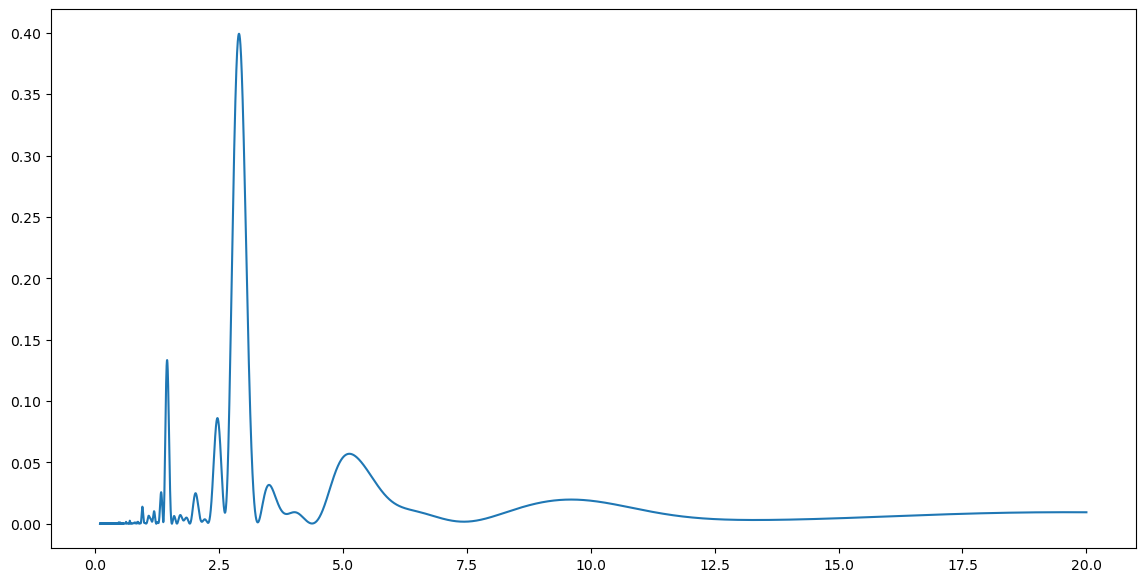

In [13]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

Now for the measurement.

In [14]:
period, power = LS_Period(time, flux, pmax=20.0)

print('Our period: ' + str(period))
print('Our power: ' + str(power))
print('Curtis period: ' + str(curtis_rot['Prot'][target_index]))

Our period: 2.8928600050493785
Our power: 0.39807060674176753
Curtis period: 2.7953


Pretty close! Now, you can proceed by testing using the other light curves we generated. You can compare the measurements between TESS sectors for a given target. Once you are comfortable with that, you can try testing other targets. If you want, you can make an algorithm that runs through and measures periods for the whole cluster. Then you can compare your measurements to the literature periods on the whole and plot your own color-period diagram and compare to the one we plotted above. If you feel comfortable with that, try moving on to measuring periods for another new cluster.

## Use light curve data products

We already downloaded FFIs from the MAST archive above and used the Causal Pixel Modeling procedure to extract light curves using our own parameters. There are also TESS Mission light curves available on MAST, as well as other data products such as light curves from the TGLC project (https://ui.adsabs.harvard.edu/abs/2023AJ....165...71H/abstract). We can compare the light curves from these data products and their associated period measurements to those we extracted and measured above. Let's start with looking at a TESS Mission light curve.

In [15]:
from astroquery.mast import Observations

In [16]:
target_coord = SkyCoord(curtis_rot['RA_ICRS'][0], curtis_rot['DE_ICRS'][0], unit=(units.deg, units.deg))

obs_table = Observations.query_criteria(coordinates=target_coord, radius=5*units.arcsec, obs_collection="TESS")

obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str13,str1,int64,str107,str1,str73,str6,bool,float64,str9,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2021232031932-s0042-0000000026127347-0213-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,59447.18968351852,59472.625405405095,120.0,600.0,1000.0,--,59494.0,G04236_G04240,--,42,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2021232031932-s0042-0000000026127347-0213-s_lc.fits,PUBLIC,False,nan,63397542,119148022,119148022,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0042-4-4,52.57462948709196,25.84794272953421,image,"Ricker, George",3,59447.186925752314,59472.66152475694,475.199778,600.0,1000.0,--,59494.0,N/A,--,42,POLYGON 60.343964 21.211661 48.014882 18.537396 44.363673 30.301323 57.530347 32.749312 60.343964 21.211661,--,--,PUBLIC,False,nan,63630607,119596533,119596533,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2021258175143-s0043-0000000026127347-0214-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,59473.66854821759,59498.381512291664,120.0,600.0,1000.0,--,59526.0,G04236_G04240,--,43,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2021258175143-s0043-0000000026127347-0214-s_lc.fits,PUBLIC,False,nan,65357854,123390560,123390560,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0043-3-1,54.160367685111915,26.37990947874032,image,"Ricker, George",3,59473.66845744213,59498.392545393515,475.19979,600.0,1000.0,--,59526.0,N/A,--,43,POLYGON 46.132592 30.450599 59.144728 33.709346 61.883929 21.728698 49.504509 19.04013 46.132592 30.450599,--,--,PUBLIC,False,nan,65432603,124285093,124285093,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2021284114741-s0044-0000000026127347-0215-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,59499.69131032407,59523.94508042824,120.0,600.0,1000.0,--,59563.0,G04236_G04240,--,44,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2021284114741-s0044-0000000026127347-0215-s_lc.fits,PUBLIC,False,nan,68721847,132329541,132329541,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0044-1-2,55.82257500335043,26.602796576207208,image,"Ricker, George",3,59499.69111061343,59523.94220331019,475.19979,600.0,1000.0,--,59563.0,N/A,--,44,POLYGON 63.625383 21.939242 51.217045 19.296045 47.555551 31.06773 60.845472 33.495286 63.625383 21.939242,--,--,PUBLIC,False,nan,68942175,133650338,133650338,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2023263165758-s0070-0000000026127347-0265-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,60208.061574328705,60233.30640929398,120.0,600.0,1000.0,--,60262.0,G06120,--,70,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2023263165758-s0070-0000000026127347-0265-s_lc.fits,PUBLIC,False,nan,191163732,346773914,346773914,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0070-4-1,51.839658811063046,24.516414511671513,image,"Ricker, George",3,60207.85150359954,60233.32315289352,158.399927,600.0,1000.0,--,60262.0,N/A,--,70,POLYGON 43.879186 28.481842 56.572338 31.927105 59.557608 20.002963 47.369366 17.110609 43.879186 28.481842,--,--,PUBLIC,False,nan,192419019,350607451,350607451,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2023289093419-s0071-0000000026127347-0266-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,60234.049510983794,60259.3614

In [17]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries")


lightcurves

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str13,str1,int64,str107,str1,str73,str6,bool,float64,str9,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2021232031932-s0042-0000000026127347-0213-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,59447.18968351852,59472.625405405095,120.0,600.0,1000.0,--,59494.0,G04236_G04240,--,42,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2021232031932-s0042-0000000026127347-0213-s_lc.fits,PUBLIC,False,nan,63397542,119148022,119148022,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2021258175143-s0043-0000000026127347-0214-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,59473.66854821759,59498.381512291664,120.0,600.0,1000.0,--,59526.0,G04236_G04240,--,43,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2021258175143-s0043-0000000026127347-0214-s_lc.fits,PUBLIC,False,nan,65357854,123390560,123390560,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2021284114741-s0044-0000000026127347-0215-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,59499.69131032407,59523.94508042824,120.0,600.0,1000.0,--,59563.0,G04236_G04240,--,44,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2021284114741-s0044-0000000026127347-0215-s_lc.fits,PUBLIC,False,nan,68721847,132329541,132329541,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2023263165758-s0070-0000000026127347-0265-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,60208.061574328705,60233.30640929398,120.0,600.0,1000.0,--,60262.0,G06120,--,70,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2023263165758-s0070-0000000026127347-0265-s_lc.fits,PUBLIC,False,nan,191163732,346773914,346773914,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2023289093419-s0071-0000000026127347-0266-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,60234.049510983794,60259.36148623843,120.0,600.0,1000.0,--,60282.0,G06120,--,71,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2023289093419-s0071-0000000026127347-0266-s_lc.fits,PUBLIC,False,nan,197687290,359271800,359271800,0.0


Here we see that we have a .fits light curve file for each sector for which we have an observation for this target. Above we looked at the light curve we extracted from the Sector 70 FFI cutout. Let's download and plot the TESS mission light curve for Sector 70 to compare.

In [23]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[70])

lightcurves

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str13,str1,int64,str107,str1,str73,str6,bool,float64,str9,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2023263165758-s0070-0000000026127347-0265-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,60208.061574328705,60233.30640929398,120.0,600.0,1000.0,--,60262.0,G06120,--,70,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2023263165758-s0070-0000000026127347-0265-s_lc.fits,PUBLIC,False,nan,191163732,346773914,346773914,0.0


In [24]:
lightcurves['productFilename'] = ['TESS_Mission_LC_67618285777617664-Sector_70.fits']
lightcurves.rename_column('dataURL', 'dataURI')

In [25]:
lightcurves

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURI,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance,productFilename
str7,str4,str4,str10,str4,str4,str7,str8,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str13,str1,int64,str107,str1,str73,str6,bool,float64,str9,str9,str9,float64,str48
science,TESS,SPOC,Photometer,TESS,TESS,Optical,26127347,--,tess2023263165758-s0070-0000000026127347-0265-s,53.8820594992889,22.8235856484482,timeseries,"Ricker, George",3,60208.061574328705,60233.30640929398,120.0,600.0,1000.0,--,60262.0,G06120,--,70,CIRCLE 53.8820595 22.82358565 0.00138889,--,mast:TESS/product/tess2023263165758-s0070-0000000026127347-0265-s_lc.fits,PUBLIC,False,nan,191163732,346773914,346773914,0.0,TESS_Mission_LC_67618285777617664-Sector_70.fits


In [26]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Pleiades_LC/')

In [27]:
from astropy.io import fits

In [32]:
target_lc = fits.open('TESS_Mission_Pleiades_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LC_67618285777617664-Sector_70.fits')[1]

target_lc.data

FITS_rec([(3208.35194079, 0.00287775, 1426244, nan, nan, nan, nan, nan, nan, 16552, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3208.35332979, 0.00287786, 1426245, nan, nan, nan, nan, nan, nan, 16416, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3208.35471879, 0.00287798, 1426246, nan, nan, nan, nan, nan, nan, 16416, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          ...,
          (3233.82040527, 0.0046873 , 1444580, nan, nan, nan, nan, nan, nan,    16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3233.82179422, 0.00468737, 1444581, nan, nan, nan, nan, nan, nan,    16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3233.82318318, 0.00468744, 1444582, nan, nan, nan, nan, nan, nan,    16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
         dtype=(numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('SAP_FLUX', '>f4'), ('SAP_FLUX_ERR', '>f4'), ('SAP_BKG', '>f4'), ('SAP_BKG_ERR', '

In [33]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18339 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [34]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

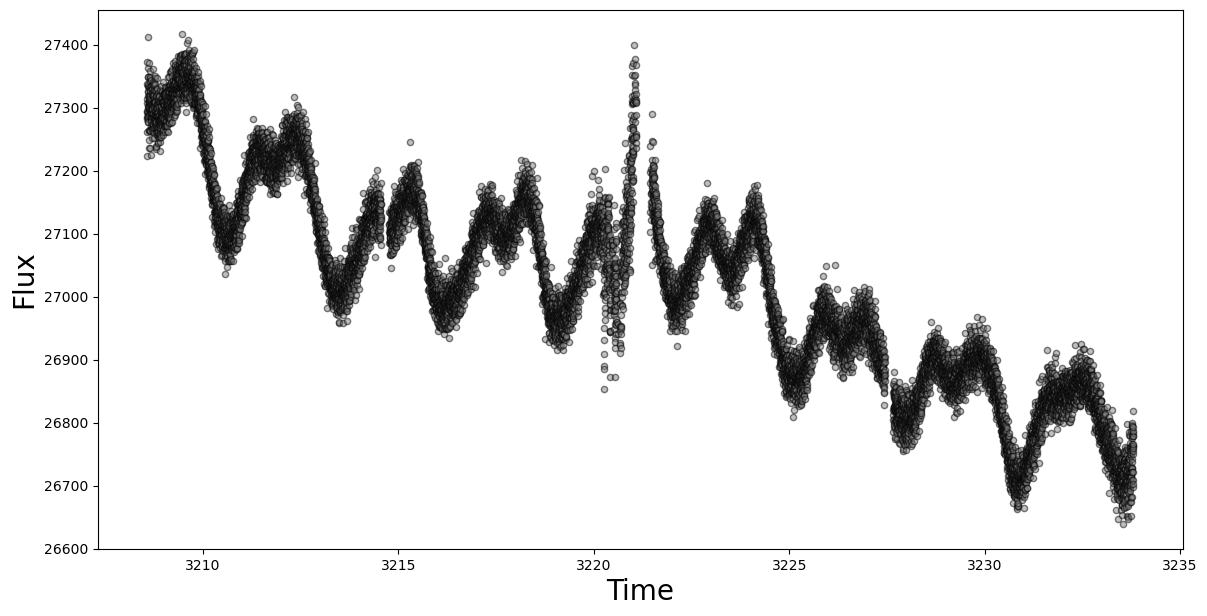

In [35]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()